In [1]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.optimize import minimize
import george
from george import kernels
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit

In [2]:
# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

# calculate aic for regression
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

def metrics(y1, y2, verbose=True, n_param=1):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    
    n = len(y1)

    mse = np.mean((y1-y2)**2)

    RMSE = np.sqrt(mse)
    MAE = np.mean(np.abs(y1-y2))
    R2 = np.max([r2_score(y1, y2),r2_score(y2, y1)])
    
    BIC = calculate_bic(n, mse, n_param)
    AIC = calculate_aic(n, mse, n_param)

    if verbose:
        print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
        print('AIC: %.2f'%AIC, ' BIC: %.2f'%BIC)

    return MAE, RMSE, R2, AIC, BIC

########################################

In [3]:
df = pd.read_csv("Tmin_QC.csv", encoding = "ISO-8859-1", engine='python')
# df["SKN"] = df.SKN.astype('str')
df.head(50)

,SKN,Station.Name,Observer,Network,Island,ELEV.m.,LAT,LON,NCEI.id,NWS.id,...,X2019.12.22,X2019.12.23,X2019.12.24,X2019.12.25,X2019.12.26,X2019.12.27,X2019.12.28,X2019.12.29,X2019.12.30,X2019.12.31
0,2.32,SOUTH KONA 2 2.32,COOP,COOP,BI,647.0000,19.107780,-155.789440,USC00518652,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.90,LOWER KAHUKU CS,LOWER KAHUKU CS,RAWS,BI,953.7192,19.100833,-155.669722,NaN,LKHH1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.20,Nene Cabin,Nene Cabin,RAWS,BI,710.4888,19.348056,-155.125833,NaN,AHMH1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.15,SEA MOUNTAIN 12.15,SEA MOUNTAIN,COOP,BI,21.0000,19.133103,-155.515274,USC00518600,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.00,NAALEHU 14,KAU SUGAR,COOP,BI,206.0000,19.060328,-155.585550,USC00516588,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,21.30,PAHALA MAUKA 21.3,COOP,COOP,BI,332.0000,19.206670,-155.488610,USC00517437,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,23.00,KAHUKU,RAWS,RAWS,BI,1796.4912,19.232222,-155.780000,NaN,KRCH1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,24.10,OPIHIHALE 2 24.1,TRUMAN LORNA,COOP,BI,396.0000,19.270322,-155.873877,USC00517166,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,24.40,KAOHE MAKAI 24.4,COOP,COOP,BI,37.0000,19.317000,-155.883000,USC00513146,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,26.20,KEALAKEKUA 26.2,GREENWELL ESTATE,COOP,BI,442.0000,19.489757,-155.912213,USC00513977,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df.dtypes)

SKN             float64
Station.Name     object
Observer         object
Network          object
Island           object
                 ...   
X2019.12.27     float64
X2019.12.28     float64
X2019.12.29     float64
X2019.12.30     float64
X2019.12.31     float64
Length: 10970, dtype: object


In [5]:
df.columns[:20]

Index(['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
       'SMART_NODE_RF.id', 'X1990.01.01', 'X1990.01.02', 'X1990.01.03',
       'X1990.01.04', 'X1990.01.05', 'X1990.01.06', 'X1990.01.07'],
      dtype='object')

In [1]:
meta_columns = ['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
       'SMART_NODE_RF.id']
Temp_columns = df.columns[13:]
Temp_columns

NameError: name 'df' is not defined

In [2]:
df2 = df[meta_columns]

df2 = df2.set_index("SKN")

print(len(df2))

df2.head()

NameError: name 'df' is not defined

In [8]:
df2.groupby("Island").count()

,Station.Name,Observer,Network,ELEV.m.,LAT,LON,NCEI.id,NWS.id,NESDIS.id,SCAN.id,SMART_NODE_RF.id
Island,,,,,,,,,,,
BI,66,66,66,66,66,66,40,27,24,0,0
KA,20,20,20,20,20,20,16,7,6,0,0
KO,6,6,6,6,6,6,6,6,5,0,0
LA,3,3,3,3,3,3,3,2,1,0,0
MA,37,37,37,37,37,37,13,5,4,0,0
MO,8,8,8,8,8,8,7,5,3,0,0
OA,46,46,46,46,46,46,37,18,16,0,0


In [9]:
# df2 = df2[(df2.Island=='BI')|(df2.Island=='Bi')]
df2 = df2[(df2.Island=='OA')]
print(len(df2))

df2.head()

46


,Station.Name,Observer,Network,Island,ELEV.m.,LAT,LON,NCEI.id,NWS.id,NESDIS.id,SCAN.id,SMART_NODE_RF.id
SKN,,,,,,,,,,,,
702.2,HONOLULU OBSERV 702.2,USC&GEODETIC SURVEY,COOP,OA,2.0,21.313926,-157.999529,USC00511918,NaN,NaN,NaN,NaN
703.0,HONOLULU INTERNATIONAL AIRPORT,USWB,NWS,OA,2.1,21.324000,-157.929400,USW00022521,NaN,NaN,NaN,NaN
707.2,EWA KALAELOA AIRPORT,LYDECKER RC,STATE,OA,14.0,21.304891,-157.830590,USW00022551,NaN,NaN,NaN,NaN
707.4,Maryknoll School 707.4,COOP,COOP,OA,15.0,21.301000,-157.833000,USC00516141,NaN,NaN,NaN,NaN
717.2,WAIKIKI 717.2,PURINTON J,COOP,OA,3.0,21.271837,-157.818092,USC00519397,NaN,NaN,NaN,NaN


In [10]:
df1 = df[["SKN"]+list(Temp_columns)].T

new_header = df1.iloc[0]
df1 = df1[1:] 
df1.columns = new_header 

df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
df1.index.name = 'Date'

df1 = df1[list(df2.index.values)]

# df1 = df1.resample('1M').mean()

print(len(df1))
df1.head(5)

10957


SKN,702.2,703.0,707.2,707.4,717.2,725.6,726.1,728.2,741.0,742.4,...,870.0,874.3,885.7,886.9,892.2,901.2,903.1,904.1,909.0,911.1
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,20.6,22.2,NaN,NaN,21.1,15.0,NaN,NaN,NaN,NaN,...,NaN,18.141993,NaN,NaN,19.4,19.4,20.0,22.106599,20.741945,NaN
1990-01-02,20.6,22.2,NaN,NaN,22.2,15.6,NaN,NaN,NaN,NaN,...,NaN,18.141993,NaN,NaN,19.4,20.6,23.3,20.725633,20.024627,NaN
1990-01-03,21.7,22.8,NaN,NaN,22.2,15.6,NaN,NaN,NaN,NaN,...,12.2,18.659569,NaN,NaN,20.0,21.1,23.3,21.213033,20.277798,NaN
1990-01-04,18.3,22.2,NaN,NaN,21.7,15.6,NaN,NaN,NaN,NaN,...,18.3,17.710680,NaN,NaN,18.9,21.1,22.8,21.619199,20.488774,NaN
1990-01-05,20.6,22.8,NaN,NaN,18.9,15.6,NaN,NaN,NaN,NaN,...,19.4,19.177145,NaN,NaN,20.6,21.1,NaN,22.106599,20.741945,NaN


In [11]:
df2.columns

Index(['Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.', 'LAT',
       'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id', 'SMART_NODE_RF.id'],
      dtype='object')

In [12]:
df3 = df2[["LON", "LAT", "ELEV.m."]].T
df3 = df3[list(df2.index.values)]
df3

SKN,702.2,703.0,707.2,707.4,717.2,725.6,726.1,728.2,741.0,742.4,...,870.0,874.3,885.7,886.9,892.2,901.2,903.1,904.1,909.0,911.1
LON,-157.999529,-157.9294,-157.830590,-157.833,-157.818092,-158.094476,-158.11,-158.104167,-158.033922,-158.020556,...,-158.027805,-158.008918,-157.93690,-157.8374,-158.058759,-157.9450,-157.929193,-157.910027,-157.989444,-157.952500
LAT,21.313926,21.3240,21.304891,21.301,21.271837,21.395455,21.34,21.385000,21.340171,21.356667,...,21.569881,21.508495,21.47747,21.5213,21.638859,21.6793,21.645154,21.609876,21.679167,21.688333
ELEV.m.,2.000000,2.1000,14.000000,15.000,3.000000,510.000000,2.00,722.376000,12.000000,1.524000,...,323.000000,340.000000,698.90000,7.0000,8.000000,7.6000,2.000000,1.000000,181.660800,1.524000


<ipython-input-13-1c922e9583bb>:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')
<ipython-input-13-1c922e9583bb>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
<ipython-input-13-1c922e9583bb>:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


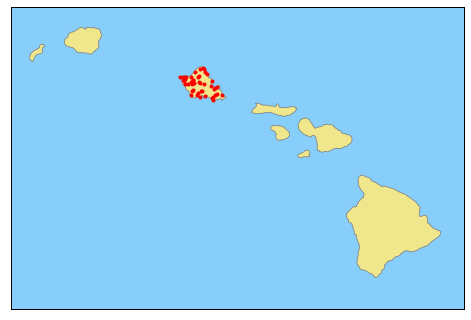

In [13]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_axes([0.05,0.05,0.9,0.9])

map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')

shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


map.drawmapboundary(fill_color='lightskyblue')

for lon, lat in list(zip(df2.LON.values, df2.LAT.values)):
    
    x, y = map(lon, lat)
    map.plot(x, y, marker='o',color='red',markersize=3)

for nshape, shapedict in enumerate(map.states_info):
     if shapedict['NAME'] in ['Hawaii']:
         seg = map.states[int(shapedict['SHAPENUM'] - 1)]
         poly = Polygon(seg, facecolor='khaki', edgecolor='gray', linewidth=.45)
         ax.add_patch(poly)

# ax.annotate("Oahu",(-158.27,21.8), fontsize=12)
# ax.annotate("Maui",(-156.28,20.98), fontsize=12)
# ax.annotate("Hawaii",(-155.8,19.54), fontsize=12)
# ax.annotate("Molokai",(-157.23,21.31), fontsize=12)
# ax.annotate("Kauai",(-159.7,21.7), fontsize=12)
# ax.annotate("Lanai",(-157.55,20.74), fontsize=12)

# ax.annotate("HAWAII",(-160.24,18.75), fontsize=16)

In [14]:
df_station =  df3.T
df_station = df_station.join(df1.T, how='left')

print(len(df_station))

df_station.head()

46


,LON,LAT,ELEV.m.,1990-01-01 00:00:00,1990-01-02 00:00:00,1990-01-03 00:00:00,1990-01-04 00:00:00,1990-01-05 00:00:00,1990-01-06 00:00:00,1990-01-07 00:00:00,...,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
SKN,,,,,,,,,,,,,,,,,,,,,
702.2,-157.999529,21.313926,2.0,20.6,20.6,21.7,18.3,20.6,16.7,15.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
703.0,-157.929400,21.324000,2.1,22.2,22.2,22.8,22.2,22.8,18.9,17.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
707.2,-157.830590,21.304891,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
707.4,-157.833000,21.301000,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717.2,-157.818092,21.271837,3.0,21.1,22.2,22.2,21.7,18.9,17.2,17.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_station.columns[3:][::-1]

Index([2019-12-31 00:00:00, 2019-12-30 00:00:00, 2019-12-29 00:00:00,
       2019-12-28 00:00:00, 2019-12-27 00:00:00, 2019-12-26 00:00:00,
       2019-12-25 00:00:00, 2019-12-24 00:00:00, 2019-12-23 00:00:00,
       2019-12-22 00:00:00,
       ...
       1990-01-10 00:00:00, 1990-01-09 00:00:00, 1990-01-08 00:00:00,
       1990-01-07 00:00:00, 1990-01-06 00:00:00, 1990-01-05 00:00:00,
       1990-01-04 00:00:00, 1990-01-03 00:00:00, 1990-01-02 00:00:00,
       1990-01-01 00:00:00],
      dtype='object', length=10957)

In [16]:
def linear(x, a, b):
    return a*x+b

def bilinear(x, a, b, c):
    
    left  = a*x+b
    right = c*(x-2150) + (a*2150+b) 
    
    try:
        y = np.asarray([left[i] if x[i]<=2150 else right[i] for i in range(len(x))])
        return y
    except:
        if x<=2150:
            return left
        else:
            return right

        
def ourliers(X, y):
    
    # plt.plot(X[:,2], y, 'o', mfc='white')
    u = np.arange(np.round(np.max(X[:,2])))

    fit, cov = curve_fit(linear, X[:,2], y, sigma=y*0+1)
    v1 = linear(u, fit[0], fit[1])

    fit, cov = curve_fit(bilinear, X[:,2], y, sigma=y*0+1)



    model = bilinear(X[:,2], fit[0], fit[1], fit[2])

    indx, = np.where(np.abs(model-y)<3)

    fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)


    model = bilinear(X[:,2], fit[0], fit[1], fit[2])

    indx, = np.where(np.abs(model-y)<3)

    fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)

    # plt.plot(u, v1)

    v2 = bilinear(u, fit[0], fit[1], fit[2])
#     plt.plot(u, v2)

    # plt.plot(X[:,2][indx], y[indx], '.')
    # print(fit)
    
    
    lin_model = bilinear(X[:,2][indx], fit[0], fit[1], fit[2])
    data = y[indx]

    MAE, RMSE, R2, AIC, BIC = metrics(lin_model, data, verbose=False, n_param=3)
    return indx, fit[0], fit[1], fit[2], MAE, RMSE, R2, AIC, BIC

In [17]:
def esnModel(theta, X_train, X_test, y_train, y_test, Hinv=2150, biLinear=False):
    
        zp = theta[0]
        slope = theta[1]
        l1 = np.exp(theta[2])
        l2 = np.exp(theta[3])
        sigma = np.exp(theta[4])
        err = np.exp(theta[5])
        
        if biLinear:
            s2 = theta[6]
        

        y_model = slope*X_train[:,2]+zp
        
        if biLinear:
            ind, = np.where(X_train[:,2]>Hinv)
            y_model[ind] += s2*(X_train[:,2][ind]-Hinv)

        kernel = sigma * kernels.ExpSquaredKernel([l1 , l2], ndim=2)
        gp = george.GP(kernel)
        gp.compute(X_train[:,:2], err)

        y_res_test, cov = gp.predict(y_train-y_model, X_test[:,:2], return_var=True)

        y_model_test = slope*X_test[:,2]+zp
        
        if biLinear:
            ind, = np.where(X_test[:,2]>Hinv)
            y_model_test[ind] += s2*(X_test[:,2][ind]-Hinv)    
        
        
        return y_res_test+y_model_test, cov

In [18]:
def nll_fn2(X, y, biLinear=False):
    def step(theta):
        loo = LeaveOneOut()
        XI2 = 0
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            model_out, cov = esnModel(theta, X_train, X_test, y_train, y_test, biLinear=biLinear)
            XI2 += np.sum((model_out - y_test)**2)
        return XI2
    return step


def solver(X, y, indx, biLinear=False, n_iter=5):
    
    j_iter = 0
    T0 = 0.
    output = []
    while j_iter<n_iter:

        try:
            # Maximum Likelihood
            
            if biLinear:
                res = minimize(nll_fn2(X[indx], y[indx], biLinear=biLinear), [T0, -0.001, 1, 1, 0.1, -1, -0.001], method='SLSQP', 
                          bounds=((None, None), (-0.1, 0), 
                                  (None, 10), (None,10), (None, 20), (-10,1), (-0.1, 0.1)))

            else: 
                res = minimize(nll_fn2(X[indx], y[indx], biLinear=biLinear), [T0, -0.001, 1, 1, 0.1, -1], method='SLSQP', 
                          bounds=((None, None), (-0.1, 0), 
                                  (None, 10), (None,10), (None, 20), (-10,1)))


            theta = res.x
            loo = LeaveOneOut()

            X_ = X[indx]
            y_ = y[indx]

            u = []
            v = []

            for train_index, test_index in loo.split(X_):
                X_train, X_test = X_[train_index], X_[test_index]
                y_train, y_test = y_[train_index], y_[test_index]

                model_out, cov = esnModel(theta, X_train, X_test, y_train, y_test, biLinear=biLinear)  

                u.append(model_out[0])
                v.append(y_test[0])
                
            R2_1 = r2_score(np.asarray(u), np.asarray(v))
            R2_2 = r2_score(np.asarray(v), np.asarray(u))
            
            R2 = np.max([R2_1, R2_2])

            output.append([R2, theta])

            T0 = np.random.uniform(0, 50)
#             print(iter, T0, '%.3f'%R2)
            j_iter+=1
        except:
            T0 = np.random.uniform(0, 50)
#             print(iter, T0)
            continue
        

    
    return output

In [19]:
Hyper = {}
Hyper['date'] = []
Hyper['zp'] = []
Hyper['slope'] = []
Hyper['l1'] = []
Hyper['l2'] = []
Hyper['sigma'] = []
Hyper['error'] = []
Hyper['S2'] = []

Hyper['MAE'] = []
Hyper['RMSE'] = []
Hyper['R2'] = []
Hyper['AIC'] = []
Hyper['BIC'] = []

Hyper['a'] = []
Hyper['b'] = []
Hyper['c'] = []

Hyper['MAE_lin'] = []
Hyper['RMSE_lin'] = []
Hyper['R2_lin'] = []
Hyper['AIC_lin'] = []
Hyper['BIC_lin'] = []

df_station =  df3.T
df_station = df_station.join(df1.T, how='left')

In [20]:
dt_cols = df_station.columns[7600:]

In [21]:
t1 =  datetime.now()
###########################################
for dt_col in dt_cols:
    
    if True: #try:
        date_str = str(dt_col.date())

        Date = pd.to_datetime(date_str)

        data = df_station[["LON", "LAT", "ELEV.m.", Date]].dropna()
        X = data[["LON", "LAT", "ELEV.m."]].values
        SKN = data.index.values
        y = data[Date].values
        

        if len(data) > 1:
            
            Hmax = np.max(X[:,2])
            if Hmax>2150:
                biLinear=True
                n_param=7
                linn_param = 3
            else:
                biLinear=False
                n_param=6
                linn_param = 2

            indx, a, b, c, MAE_lin, RMSE_lin, R2_lin, AIC_lin, BIC_lin  = ourliers(X, y)
            output = solver(X, y, indx, biLinear=biLinear)

            output.sort(key= lambda x: x[0], reverse=True)

            theta = output[0][1]
            R2 = output[0][0]

            colName = str(Date.date())+'-M'

            loo = LeaveOneOut()

            X_ = X[indx]
            y_ = y[indx]

            u = y_*0+np.nan
            u_e = y_*0+np.nan

            for train_index, test_index in loo.split(X_):
                X_train, X_test = X_[train_index], X_[test_index]
                y_train, y_test = y_[train_index], y_[test_index]

                model_out, cov = esnModel(theta, X_train, X_test, y_train, y_test, biLinear=biLinear)  
                u[test_index] = model_out
                u_e[test_index] = np.sqrt(cov)

            m = y*0+np.nan
            m_e = y*0+np.nan
            m[indx] = u
            m_e[indx] = u_e
            m[np.abs(m-y)>10]=np.nan

            data[colName] = m
            data[colName+'_err'] = m_e

            df_station = df_station.join(data[[colName, colName+'_err']], how='left')
            df_station.reset_index().to_csv("test.2019.csv", sep=',', index=False)

            Hyper['date'].append(date_str)
            Hyper['zp'].append(theta[0])
            Hyper['slope'].append(theta[1])
            Hyper['l1'].append(theta[2])
            Hyper['l2'].append(theta[3])
            Hyper['sigma'].append(theta[4])
            Hyper['error'].append(theta[5])
            
            if biLinear:
                Hyper['S2'].append(theta[6])
            else:
                Hyper['S2'].append(np.nan)
            
            
            y1 = y[indx]
            y2 = m[indx]

            ind, = np.where(np.abs(y1-y2)<10)
            u = y1[ind]
            v = y2[ind]

            MAE, RMSE, R2, AIC, BIC = metrics(u, v, verbose=False, n_param=n_param)
            
            
            # To make sure that the linear model is excuted using the same data
            lin_model = bilinear(X[:,2][indx][ind], a, b, c)
            data = y[indx][ind]
            MAE_lin, RMSE_lin, R2_lin, AIC_lin, BIC_lin = metrics(lin_model, data, 
                                                                  verbose=False, n_param=linn_param)
            

            Hyper['MAE'].append(MAE)
            Hyper['RMSE'].append(RMSE)
            Hyper['R2'].append(R2)
            Hyper['AIC'].append(AIC)
            Hyper['BIC'].append(BIC)
            
            Hyper['a'].append(a)
            Hyper['b'].append(b)
            Hyper['c'].append(c)
            
            Hyper['MAE_lin'].append(MAE_lin)
            Hyper['RMSE_lin'].append(RMSE_lin)
            Hyper['R2_lin'].append(R2_lin)
            Hyper['AIC_lin'].append(AIC_lin)
            Hyper['BIC_lin'].append(BIC_lin)
            
            pd.DataFrame.from_dict(Hyper).to_csv("test.Hyper.csv", sep=',', index=False)

            print(date_str)
#     except:
#         pass
    
    print(Hyper)
    break
        
###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

/home/ehsan/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-21-ea2119153efe>:58: RuntimeWarning: invalid value encountered in greater
  m[np.abs(m-y)>10]=np.nan


2010-10-20
{'date': ['2010-10-20'], 'zp': [224.09969222608038], 'slope': [-0.00256248047775179], 'l1': [-1.7924141959901974], 'l2': [10.0], 'sigma': [-12.112695078127105], 'error': [-9.785084842040341], 'S2': [nan], 'MAE': [0.9205817144222161], 'RMSE': [1.128689560955164], 'R2': [0.45987694808700275], 'AIC': [19.021322193818275], 'BIC': [27.22509717373712], 'a': [-0.004463836127465388], 'b': [20.00482426395114], 'c': [1.0], 'MAE_lin': [1.072897587742994], 'RMSE_lin': [1.330764164763209], 'R2_lin': [0.249162610121488], 'AIC_lin': [20.573693558157736], 'BIC_lin': [23.308285218130685]}
Execution time:
0:01:44.573082


<ipython-input-22-45886b8f2352>:21: RuntimeWarning: invalid value encountered in greater
  m[np.abs(m-y)>10]=np.nan


Text(0, 0.5, 'Temperature [oC]')

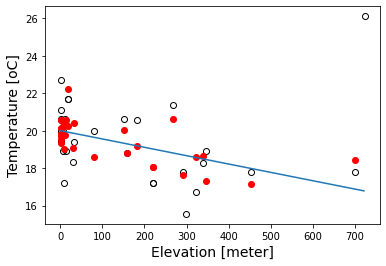

In [22]:
plt.plot(df3.iloc[2].values, df1.loc[Date].values, 'ko', mfc='none')

loo = LeaveOneOut()

X_ = X[indx]
y_ = y[indx]

u = y_*0+np.nan

for train_index, test_index in loo.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_[train_index], y_[test_index]

    model_out, cov = esnModel(theta, X_train, X_test, y_train, y_test, biLinear=biLinear)  

    u[test_index] = model_out


m = y*0+np.nan
m[indx] = u
m[np.abs(m-y)>10]=np.nan
plt.plot(X[:,2], m, 'ro')       

xx = np.arange(np.round(np.max(X[:,2])))
yy = bilinear(xx, a, b, c)
plt.plot(xx,yy)

plt.xlabel("Elevation [meter]", fontsize=14)
plt.ylabel("Temperature [oC]", fontsize=14)

MAE: 0.92  RMSE: 1.13  R^2: 0.46
AIC: 9.02  BIC: 10.39


(0.9205817144222161,
 1.128689560955164,
 0.45987694808700275,
 9.021322193818275,
 10.38861802380475)

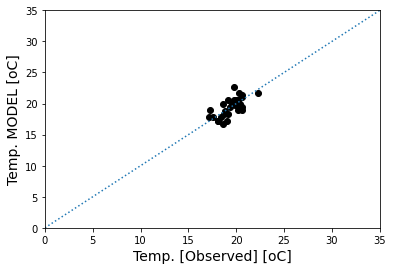

In [23]:
y1 = y[indx]
y2 = m[indx]

ind, = np.where(np.abs(y1-y2)<10)
u = y1[ind]
v = y2[ind]

plt.plot(v, u, 'ko')

plt.xlim(0,35)
plt.ylim(0,35)

plt.plot([0,35], [0,35], ':')

plt.ylabel("Temp. MODEL [oC]", fontsize=14)
plt.xlabel("Temp. [Observed] [oC]", fontsize=14)

metrics(u, v )

In [24]:
out_df = pd.read_csv("Oahu.2019.Hyper.csv", sep=',')

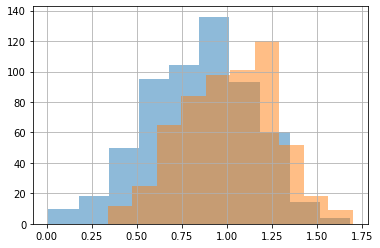

In [25]:
out_df.RMSE.hist(alpha=0.5)
out_df.RMSE_lin.hist(alpha=0.5)

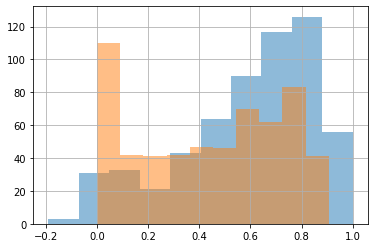

In [26]:
out_df.R2.hist(alpha=0.5)
out_df.R2_lin.hist(alpha=0.5)

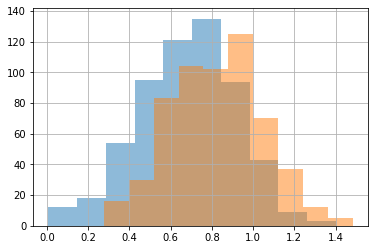

In [27]:
out_df.MAE.hist(alpha=0.5)
out_df.MAE_lin.hist(alpha=0.5)

In [28]:
string = 'Tmin_QC.csv'

string.split('.csv')[0]

'Tmin_QC'

In [96]:
_ = pd.read_csv("Tmin_QC_BI_hyper.csv", sep=',')

_[['date','zp','slope','l1','l2','R2','R2_lin']].head(5)

,date,zp,slope,l1,l2,R2,R2_lin
0,2019-07-18,24.877407,-0.006160,-2.620361,-0.114515,0.953332,0.925788
1,2019-07-17,24.355336,-0.006889,-7.005039,-3.127138,0.969859,0.940306
2,2019-07-16,23.293570,-0.006895,-2.764409,-11.895631,0.916423,0.929420
3,2019-07-15,383.559049,-0.006527,17.260009,3.360015,0.932774,0.921414
4,2019-07-14,21.926051,-0.005495,-2.320133,-4.786305,0.887907,0.900451


In [97]:
len(_)

2471

In [98]:
_[['date']].tail(5)

,date
2466,2012-10-16
2467,2012-10-15
2468,2012-10-14
2469,2012-10-13
2470,2012-10-12


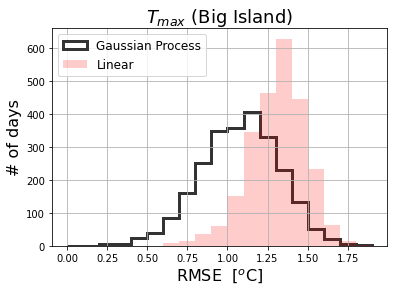

In [99]:
bins = np.arange(0,2,0.1)
_.RMSE.hist(bins=bins, alpha=0.8, histtype='step', lw=3, color='k', label='Gaussian Process') # blue
_.RMSE_lin.hist(bins=bins, alpha=0.2, lw=3, color='r', label='Linear')

plt.title(r'$T_{max}$'+' (Big Island)', fontsize=18)
plt.xlabel('RMSE  ['+r'$^o$'+'C]', fontsize=16)
plt.ylabel('# of days', fontsize=16)

plt.legend(loc=2, fontsize=12)

Text(0, 0.5, '# of days')

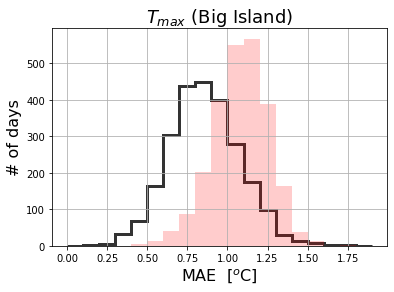

In [100]:
bins = np.arange(0,2,0.1)

_.MAE.hist(bins=bins, alpha=0.8, histtype='step', lw=3, color='k', label='Gaussian Process') # blue
_.MAE_lin.hist(bins=bins, alpha=0.2, lw=3, color='r', label='Linear')

plt.title(r'$T_{max}$'+' (Big Island)', fontsize=18)
plt.xlabel('MAE  ['+r'$^o$'+'C]', fontsize=16)
plt.ylabel('# of days', fontsize=16)

# plt.legend(loc=2, fontsize=12)

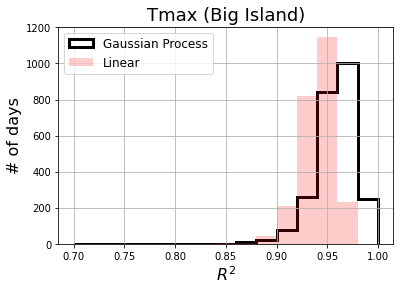

In [101]:
bins = np.arange(0.7,1,0.02)

_.R2.hist(bins=bins, alpha=1, histtype='step', lw=3, color='k', label='Gaussian Process') # blue
_.R2_lin.hist(bins=bins, alpha=0.2, lw=3, color='r', label='Linear')

plt.title('Tmax (Big Island)', fontsize=18)
plt.xlabel(r'$R^2$', fontsize=16)
plt.ylabel('# of days', fontsize=16)

plt.legend(loc=2, fontsize=12)

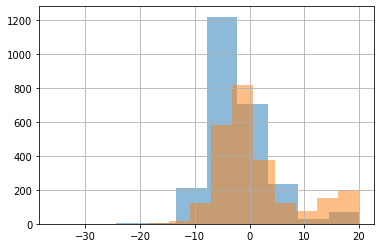

In [102]:
_.l1.hist(alpha=0.5) 
_.l2.hist(alpha=0.5) 

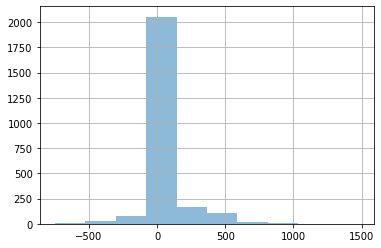

In [103]:
_.zp.hist(alpha=0.5) 

In [43]:
# df_ = pd.read_csv("Tmin_QC_OA.csv", sep=',')
# df_ = df_.set_index('SKN')
# dat = "2018-11-09"
# Date = dat + " 00:00:00"
# df_[[Date, dat+'-M', dat+'-M_err']].dropna()

In [45]:
# df_.columns